# Summer analysis 2023: Complete dataset analysis (dates)

This notebook analyses raster data {ndvi or ndmi} for a given city in a given resolution.
Possible outputs include:
* continous_behaviour: Plot continous behaviour graph (one single line throughout 5 years)
* yearly_behaviour: Plot yearly behaviour graph (one line for each year, shows seasonal behaviour) + main mean line + confidence interval
* yearly_behaviour_smooth: Plot yearly behavour graph (one line for each year, shows seasonal behaviour) + main LOWESS smoothed line + confidence interval
* value_maps: Plot analysis data {ndvi or ndmi} on a {city} map by season considering {ndvi or ndmi} net values.
    * winter = jan, feb, mar
    * spring = apr, may, jun
    * summer = jul, aug, sep
    * fall = oct, nov, dec
* categories_maps: Plot ndvi on a {city} map by season considering ndvi categories.
    * winter = jan, feb, mar
    * spring = apr, may, jun
    * summer = jul, aug, sep
    * fall = oct, nov, dec

Complete data_hex structure:
1. hex_id
2. res
3. {ndvi or ndmi}
4. month = 1,2,3,4....
5. year = 2018, 2019, 2020, 2021, 2022

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
# Libraries for LOWESS
#pip install statsmodels --upgrade

# Libraries for LOWESS
#pip install plotly

# Libraries for LOWESS (Locally Weighted Scatterplot Smoothing) regression model
# https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35
# https://stackoverflow.com/questions/56283294/importerror-cannot-import-name-factorial
import plotly.graph_objects as go # for data visualization
import statsmodels.api as sm # to build a LOWESS model

## Config notebook

In [3]:
city = 'Monterrey'
analysis_type = 'ndvi' #Only 'ndvi' or 'ndmi' possible
res = 10

In [29]:
#Export to "../../../data/external/__ a .csv containing hex_id, res, ndvi, month, year, city, date, month_str, season.
csv_dataset = False

#Plot continous behaviour graph (one single line throughout 5 years)
continous_behaviour = True

#Plot yearly behaviour graph (one line for each year, shows seasonal behaviour) + mean line
yearly_behaviour = True

#Plot yearly behavour graph (one line for each year, shows seasonal behaviour) + LOWESS smoothed line
yearly_behaviour_smooth = True

#Plot analysis data {ndvi or ndmi} on a {city} map by season
value_maps = True

#Plot ndvi on a {city} map by season considering ndvi categories
categories_maps = True #NDVI only

#Save all outputs (graphs and maps) in output > figures > ndvi_ndmi_marg_bycity > {city.lower()} (Must first create {city.lower()} folder)
save_plots = True

## Data download

### Data download - Municipality polygons

In [5]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(18, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,19001,19,001,Abasolo,"POLYGON ((-100.39267 25.98715, -100.39224 25.9...",Monterrey
1,19006,19,006,Apodaca,"POLYGON ((-100.24794 25.86462, -100.24672 25.8...",Monterrey


### Data download - Hex grid

In [6]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['19001',
 '19006',
 '19009',
 '19010',
 '19012',
 '19018',
 '19019',
 '19021',
 '19025',
 '19026',
 '19031',
 '19039',
 '19041',
 '19045',
 '19046',
 '19047',
 '19048',
 '19049']

In [7]:
# donwload hexagons
hex_grid = gpd.GeoDataFrame()
hex_grid_schema = 'hexgrid'
hex_grid_table = 'hexgrid_{}_city'.format(res)

# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_grid_schema}.{hex_grid_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_grid = pd.concat([hex_grid, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_grid.shape)
hex_grid.head(2)

(433077, 3)


,geometry,hex_id_10,CVEGEO
0,"POLYGON ((-100.38946 25.93779, -100.38878 25.9...",8a48a2388167fff,19001
1,"POLYGON ((-100.41505 25.95330, -100.41431 25.9...",8a48a2389b8ffff,19001


### Data download - Raster Analysis Data

In [8]:
# Finds hex_id codes from hex_grid
hex_ids = str(tuple(list(hex_grid["hex_id_{}".format(res)].unique())))

# Info to query
raster_schema = 'raster_analysis'
raster_folder = '{}_complete_dataset_hex'.format(analysis_type)

query = f"SELECT * FROM {raster_schema}.{raster_folder} WHERE \"hex_id\" IN {hex_ids}"
raster_dataset = aup.df_from_query(query)

print(raster_dataset.shape)
raster_dataset.head(2)

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 657, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: SSL SYSCALL error: EOF detected

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 657, in do_rollback
    dbapi_connec

(4542060, 6)


,hex_id,res,ndvi,month,year,city
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey


In [9]:
# Info to query
#raster_schema = 'raster_analysis'
#raster_folder = '{}_complete_dataset_hex'.format(analysis_type)

# Query
#query = f"SELECT * FROM {raster_schema}.{raster_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
#raster_dataset = aup.df_from_query(query)

#print(raster_dataset.shape)
#raster_dataset.head(2)

## Data treatment

Data treatment - Create datetime data

In [10]:
#Creates datetime data by adding month (string) + / + year (string)
raster_dataset['date'] = pd.to_datetime(raster_dataset['month'].astype(str) + '/' + raster_dataset['year'].astype(str))

#Strips the day, leaving month and year
raster_dataset['date'] = raster_dataset['date'].apply(lambda x: x.strftime('%Y-%m'))

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542060, 7)


,hex_id,res,ndvi,month,year,city,date
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey,2018-01
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey,2019-01


Data treatment - Name months

In [11]:
def name_month(month):
    if (month == 1):
        return 'jan'
    elif (month == 2):
        return 'feb'
    elif (month == 3):
        return 'mar'
    elif (month == 4):
        return 'apr'
    elif (month == 5):
        return 'may'
    elif (month == 6):
        return 'jun'
    elif (month == 7):
        return 'jul'
    elif (month == 8):
        return 'aug'
    elif (month == 9):
        return 'sep'
    elif (month == 10):
        return 'oct'
    elif (month == 11):
        return 'nov'
    elif (month == 12):
        return 'dec'
    else:
          return "N/A"

raster_dataset['month_str'] = raster_dataset['month'].apply(lambda x: name_month(x))
    
# Ordering months chronologically
categories = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec']
raster_dataset['month_str'] = pd.Categorical(raster_dataset['month_str'], categories=categories, ordered=True)

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542060, 8)


,hex_id,res,ndvi,month,year,city,date,month_str
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey,2018-01,jan
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey,2019-01,jan


Data treatment - Create season data

In [12]:
def find_season(month):
    if (month == 1) or (month == 2) or (month == 3):
        return "winter"
    elif (month == 4) or (month == 5) or (month == 6):
        return "spring"
    elif (month == 7) or (month == 8) or (month == 9):
        return "summer"
    elif (month == 10) or (month == 11) or (month == 12):
        return "fall"
    else:
          return "N/A"

raster_dataset['season'] = raster_dataset['month'].apply(lambda x: find_season(x))

# Ordering seasons chronologically
categories = ['winter', 'spring', 'summer', 'fall']
raster_dataset['season'] = pd.Categorical(raster_dataset['season'], categories=categories, ordered=True)

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542060, 9)


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey,2018-01,jan,winter
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey,2019-01,jan,winter


Clean data dropping NaNs, if any

In [13]:
raster_dataset = raster_dataset.dropna()

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542060, 9)


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey,2018-01,jan,winter
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey,2019-01,jan,winter


### Export complete dataset csv

In [14]:
if csv_dataset:
    csv_raster_dataset = raster_dataset.copy()
    
    #Solo año 2022
    #mave_raster_dataset = mave_raster_dataset.loc[mave_raster_dataset.year==2022]
    
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)

    #Download dataframe
    csv_raster_dataset.to_csv("../../../data/external/complete{}_{}_res{}".format(analysis_type,city.lower(),res))

## Data analysis

### Data analysis - Graph one continuous behaviour

Group by date

In [15]:
mean_bydate = raster_dataset.groupby('date').agg({analysis_type:np.mean})
mean_bydate.head(2)

,ndvi
date,
2018-01,0.212350
2018-02,0.182645


Plot continuous behaviour

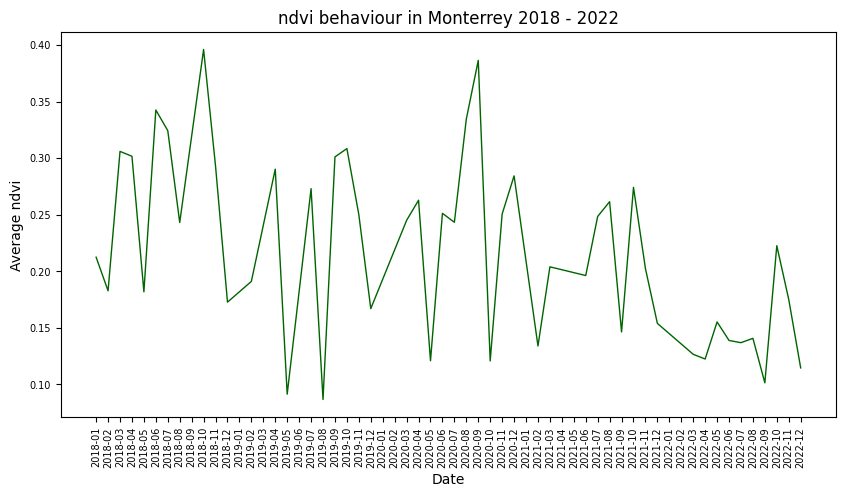

In [16]:
if continous_behaviour:
    # ---------- Plot ----------
    plt.figure(figsize=(10,5))
    plt.plot(mean_bydate, '-', color = 'darkgreen',linewidth = 1);

    # ---------- Format ----------
    # Format - Titles
    plt.title('{} behaviour in {} 2018 - 2022'.format(analysis_type,city))
    plt.xlabel('Date')
    plt.ylabel('Average {}'.format(analysis_type))

    # Format - x ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}_continuous_2018-2022_{}.svg".format(city.lower(),analysis_type,city.lower()))

### Data analysis - Graph yearly behaviour

In [17]:
#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542060, 9)


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey,2018-01,jan,winter
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey,2019-01,jan,winter


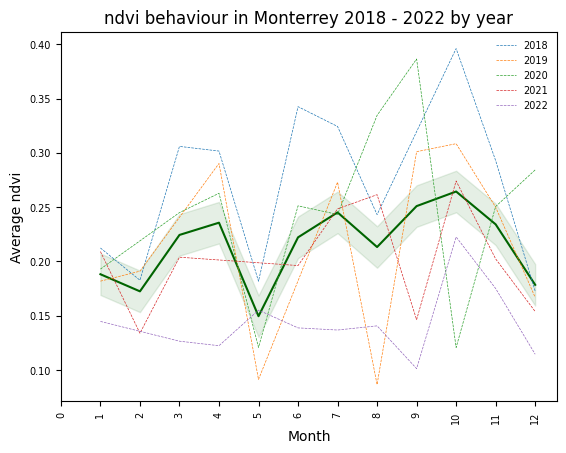

In [18]:
if yearly_behaviour:
    # ---------- Plotting whole data by month (main line) ----------
    # DATA
    complete_bymonth = raster_dataset.groupby('month').agg({analysis_type:np.mean,'month':np.mean})

    # ------- DATA AND CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth['{}'.format(analysis_type)]
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots()
    ax.plot(x,y, color = 'darkgreen')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ---------- YEARLY DATA BY MONTH (dotted lines) ----------

    # Find all data years
    available_years = list(raster_dataset['year'].unique())

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        current_raster_dataset = raster_dataset.loc[(raster_dataset.year == current_year)]
        #Grouping by month    
        yearly_bymonth = current_raster_dataset.groupby('month').agg({analysis_type:np.mean})
        #Plotting
        plt.plot(yearly_bymonth, '--', linewidth = 0.5, label=current_year);


    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('{} behaviour in {} 2018 - 2022 by year'.format(analysis_type,city))
    plt.xlabel('Month')
    plt.ylabel('Average {}'.format(analysis_type))

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=1, 
               fontsize = 7)

    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}_yearly_{}.svg".format(city.lower(),analysis_type,city.lower()))

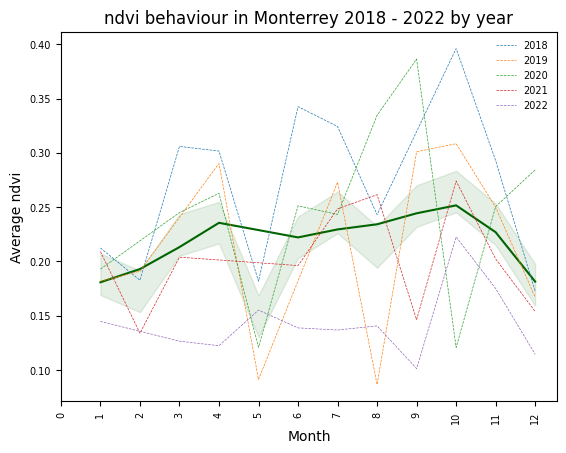

In [66]:
if yearly_behaviour_smooth:
    # ---------- Plotting whole data by month (main line) ----------
    # DATA
    complete_bymonth = raster_dataset.groupby('month').agg({analysis_type:np.mean,'month':np.mean})

    # ------- CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth['{}'.format(analysis_type)]
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots()
    #regular, mean plot
    #ax.plot(x,y, color = 'darkgreen')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ------- LOWESS PLOT -------
    x = np.array(x)
    y = np.array(y)

    smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac= 3/8) #fracc is the fraction of the data used when estimating each y-value. Default is 0.1
    plt.plot(smoothed[:, 0], smoothed[:, 1],color='darkgreen')

    # ---------- YEARLY DATA BY MONTH (dotted lines) ----------

    # Find all data years
    available_years = list(raster_dataset['year'].unique())

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        current_raster_dataset = raster_dataset.loc[(raster_dataset.year == current_year)]
        #Grouping by month    
        yearly_bymonth = current_raster_dataset.groupby('month').agg({analysis_type:np.mean})
        #Plotting
        plt.plot(yearly_bymonth, '--', linewidth = 0.5, label=current_year);

    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('{} behaviour in {} 2018 - 2022 by year'.format(analysis_type,city))
    plt.xlabel('Month')
    plt.ylabel('Average {}'.format(analysis_type))

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=1, 
               fontsize = 7)

    # ---------- Save Plot ----------
    #if save_plots:
    #    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}_yearly_smoothed_{}.svg".format(city.lower(),analysis_type,city.lower()))

### Data analysis - Maps

Show dataframe and available unique hex_ids

In [20]:
#Show dataframe
print(raster_dataset.shape)

available_hexids = list(raster_dataset['hex_id'].unique())
print(len(available_hexids))

raster_dataset.head(2)

(4542060, 9)
75701


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a20004dffff,10,0.115622,1,2018,Monterrey,2018-01,jan,winter
1,8a48a20004dffff,10,0.324162,1,2019,Monterrey,2019-01,jan,winter


In [21]:
if analysis_type == 'ndvi':
    divnorm=colors.TwoSlopeNorm(vmin=-0.2, vcenter=0.2, vmax=0.6)
    colorpalette = 'PiYG'
else:
    divnorm=colors.TwoSlopeNorm(vmin=-0.2, vcenter=0, vmax=0.2)
    colorpalette = 'BrBG'

Create maps by season considering net analyis values

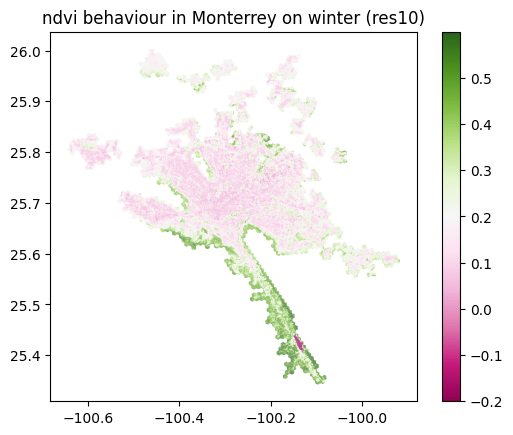

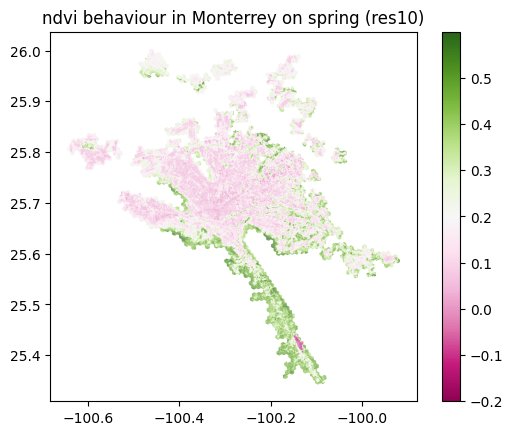

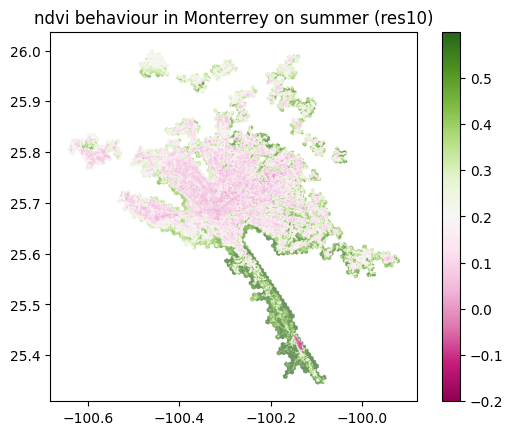

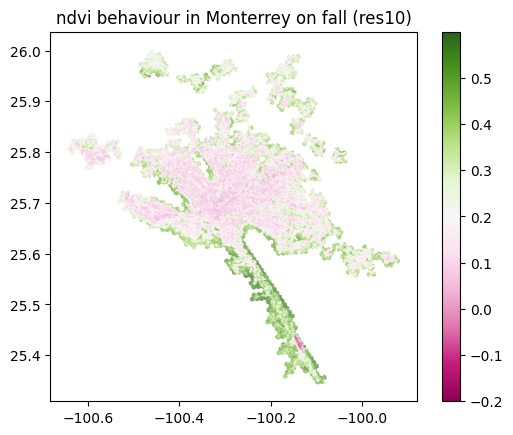

In [22]:
if value_maps:
    #Iterate over each season
    seasons = ['winter', 'spring', 'summer', 'fall']

    for current_season in seasons:
        # ---------- Isolate seasonal data ----------
        #Isolate df
        current_raster_dataset = raster_dataset.loc[(raster_dataset.season == current_season)]

        #Group by hex id    
        current_analysis = current_raster_dataset.groupby('hex_id').agg({analysis_type:np.mean})
        current_analysis = current_analysis.reset_index()

        #Join with geometry
        current_analysis_hex = pd.merge(current_analysis, hex_grid, left_on='hex_id', right_on='hex_id_{}'.format(res))

        #GeoDataFrame Format
        current_analysis_hex = gpd.GeoDataFrame(current_analysis_hex, geometry='geometry')
        current_analysis_hex = current_analysis_hex.drop(columns = ['hex_id_{}'.format(res), 'CVEGEO'])
        current_analysis_hex = current_analysis_hex.rename(columns = {'metropolis': 'city'})


        # ---------- Plot seasonal data ----------
        current_analysis_hex.plot('{}'.format(analysis_type), colorpalette, legend=True, norm=divnorm) #vmin= minvalue, vmax = maxvalue

        # ---------- Format ----------
        # Format - Titles
        plt.title('{} behaviour in {} on {} (res{})'.format(analysis_type,city,current_season,res))

        #Check
        #average = np.mean(current_analysis_hex.ndmi)
        #print(average)

        # ---------- Save Plot ----------
        if save_plots:
            plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}values_{}_{}.svg".format(city.lower(),analysis_type,current_season,city.lower()))

If analysis_type = ndvi, Create maps by season considering categorized ndvi

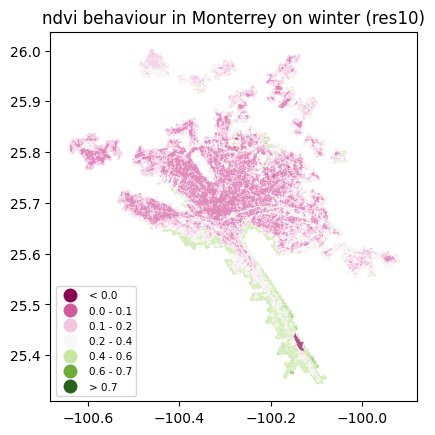

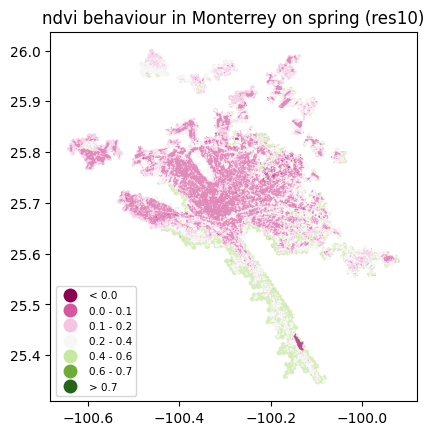

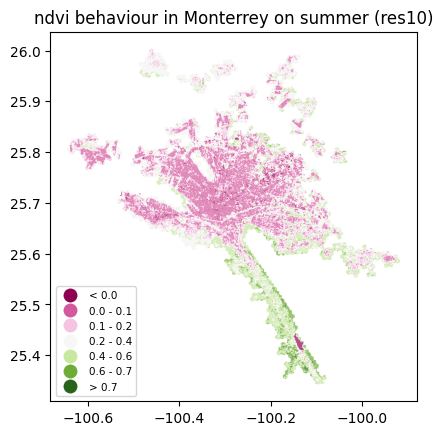

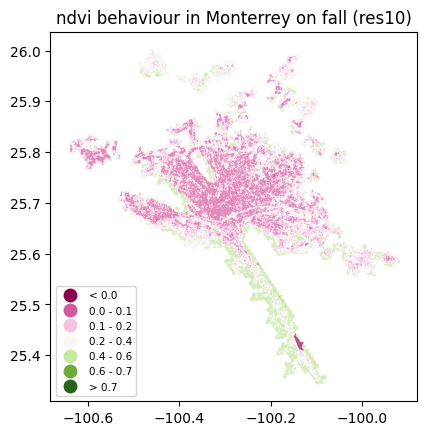

In [30]:
if categories_maps and (analysis_type == 'ndvi'):
    #Iterate over each season
    seasons = ['winter', 'spring', 'summer', 'fall']

    for current_season in seasons:
        # ---------- Isolate seasonal data ----------
        #Isolate df
        current_raster_dataset = raster_dataset.loc[(raster_dataset.season == current_season)]

        #Group by hex id    
        current_analysis = current_raster_dataset.groupby('hex_id').agg({analysis_type:np.mean})
        current_analysis = current_analysis.reset_index()

        #Join with geometry
        current_analysis_hex = pd.merge(current_analysis, hex_grid, left_on='hex_id', right_on='hex_id_{}'.format(res))

        #GeoDataFrame Format
        current_analysis_hex = gpd.GeoDataFrame(current_analysis_hex, geometry='geometry')
        current_analysis_hex = current_analysis_hex.drop(columns = ['hex_id_{}'.format(res), 'CVEGEO'])
        current_analysis_hex = current_analysis_hex.rename(columns = {'metropolis': 'city'})

        # ---------- Plot seasonal NDVI data ----------
        # Creating vegetation categories
        current_analysis_hex['nvdi_category'] = np.nan
        current_analysis_hex.loc[current_analysis_hex.ndvi>=0.7 , 'ndvi_category'] = '> 0.7'
        current_analysis_hex.loc[(current_analysis_hex.ndvi>=0.6 )&
                     (current_analysis_hex.ndvi<0.7), 'ndvi_category'] = '0.6 - 0.7'      
        current_analysis_hex.loc[(current_analysis_hex.ndvi>=0.4)&
                     (current_analysis_hex.ndvi<0.6), 'ndvi_category'] = '0.4 - 0.6'              
        current_analysis_hex.loc[(current_analysis_hex.ndvi>=0.2)&
                     (current_analysis_hex.ndvi<0.4), 'ndvi_category'] = '0.2 - 0.4'        
        current_analysis_hex.loc[(current_analysis_hex.ndvi>=0.1)&
                     (current_analysis_hex.ndvi<0.2), 'ndvi_category'] = '0.1 - 0.2'
        current_analysis_hex.loc[(current_analysis_hex.ndvi>=0)&
                     (current_analysis_hex.ndvi<0.1), 'ndvi_category'] = '0.0 - 0.1'
        current_analysis_hex.loc[(current_analysis_hex.ndvi<0), 'ndvi_category'] = '< 0.0'

        # Ordering data
        categories = ['< 0.0', '0.0 - 0.1', '0.1 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.7', '> 0.7']
        current_analysis_hex['ndvi_category'] = pd.Categorical(current_analysis_hex['ndvi_category'], categories=categories, ordered=True)

        # Plot categories
        current_analysis_hex.plot('ndvi_category',colorpalette, legend=True,
                                 legend_kwds={'fontsize':7.5,'loc':'lower left'})

        # ---------- Format ----------
        # Format - Titles
        plt.title('{} behaviour in {} on {} (res{})'.format(analysis_type,city,current_season,res))

        # ---------- Save Plot ----------
        if save_plots:
            plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}categories_{}_{}.svg".format(city.lower(),analysis_type,current_season,city.lower()))